In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

#root path
PATH = '/content/drive/My Drive/'

#data sets path
INPATH = PATH + 'training-in'
OUTPATH = PATH +'training-out'
# checkpoints path
CKPATH = PATH + 'checkpoints'

imgurls = !ls -1 "{INPATH}"

In [4]:
n = 600
train_n = round(n*0.8)

#randomized list
randurls = np.copy(imgurls)

np.random.seed(654)
np.random.shuffle(randurls)

#Partition
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls),len(tr_urls),len(ts_urls))

8189 480 120


In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

#Rescaling images
def resize(inimg, tgimg, height, width):
    
    inimg = tf.image.resize(inimg, [height, width])
    tgimg = tf.image.resize(tgimg, [height, width])
    return inimg, tgimg


#Normalizing images to be in range [-1,1]
def normalize(inimg, tgimg): 
    inimg = (inimg /127.5) - 1
    tgimg = (tgimg /127.5) - 1
    return inimg, tgimg

#Augmentation of data : Random Crop + Flip
@tf.function()
def random_jitter(inimg, tgimg):

    inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT + 30 , IMG_WIDTH + 30)

    inimg = tf.concat([inimg,inimg,inimg],2)

    stacked_image = tf.stack([inimg, tgimg], axis = 0)
    cropped_image = tf.image.random_crop(stacked_image, size = [2, IMG_HEIGHT, IMG_WIDTH,3])
      
    inimg = cropped_image[0]
    tgimg = cropped_image[1]


    if tf.random.uniform(()) < 0.5:

        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)
    
    return inimg, tgimg

def load_image(file_name, augment = True):

    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + file_name )),tf.float32)[...,:1]
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + file_name )),tf.float32)[...,:3]

    inimg, tgimg = resize(inimg, tgimg, IMG_HEIGHT,IMG_WIDTH)

    if augment:
        inimg, tgimg = random_jitter(inimg, tgimg)
    else:
        inimg = tf.concat([inimg,inimg,inimg],2)
    
    inimg, tgimg = normalize(inimg, tgimg)

    return inimg, tgimg

def load_train_image(filename):
    return load_image(filename, True)

def load_test_image(filename):
    return load_image(filename, False)

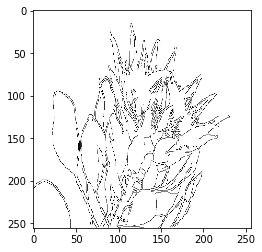

In [0]:
plt.imshow((load_test_image(randurls[104])[0]+1)/2)

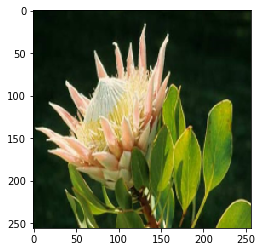

In [0]:
plt.imshow((load_train_image(randurls[104])[1]+1)/2)

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)

In [0]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters,apply_batchnorm=True):

    result = Sequential()
    
    initializer = tf.random_normal_initializer(0,0.02)

    #Convolutional layer
    result.add(Conv2D(filters,
                      kernel_size=4,
                      strides=2,
                      padding="same",
                      kernel_initializer= initializer,
                      use_bias = not apply_batchnorm))

    #Batchnorm layer
    if apply_batchnorm:
        result.add(BatchNormalization())

    # Activation layer

    result.add(LeakyReLU())

    return result

In [0]:
def upsample(filters,apply_dropout=False):

    result = Sequential()
    
    initializer = tf.random_normal_initializer(0,0.02)

    #Convolutional layer
    result.add(Conv2DTranspose(filters,
                               kernel_size=4,
                               strides=2,
                               padding="same",
                               kernel_initializer= initializer,
                               use_bias = False))

    #Batchnorm layer
    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    # Activation layer
    result.add(ReLU())

    return result

In [0]:
def generator():

    inputs = tf.keras.layers.Input(shape=[None,None,3])

    down_stack = [
        downsample(64, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128),                       # (bs, 64,  64,  128)
        downsample(256),                       # (bs, 32,  32,  256)
        downsample(512),                       # (bs, 16,  16,  512)
        downsample(512),                       # (bs, 8,   8,   512)
        downsample(512),                       # (bs, 4,   4,   512)
        downsample(512),                       # (bs, 2,   2,   512)
        downsample(512)                        # (bs, 1,   1,   512)
    ]

    up_stack = [
        upsample(512, apply_dropout=True),     # (bs, 2,   2,   1024)
        upsample(512, apply_dropout=True),     # (bs, 4,   4,   1024)
        upsample(512, apply_dropout=True),     # (bs, 8,   8,   1024)
        upsample(512),                         # (bs, 16,  16,  1024)
        upsample(256),                         # (bs, 32,  32,   512)
        upsample(128),                         # (bs, 64,  64,   512)
        upsample(64)                           # (bs, 128, 128,  128)
    ]

    initializer = tf.random_normal_initializer(0,0.02)

    last = Conv2DTranspose(filters = 3,
                           kernel_size=4,
                           strides=2,
                           padding="same",
                           kernel_initializer=initializer,
                           activation = "tanh")
    
    x = inputs
    skip_connections = []
    concat = Concatenate()

    for down in down_stack:
        x = down(x)
        skip_connections.append(x)

    skip_connections = reversed(skip_connections[:-1])
    
    for up, skip_connection in zip(up_stack,skip_connections):

        x = up(x)
        x = concat([x,skip_connection])

    last = last(x)

    return Model(inputs = inputs, outputs=last)

In [0]:
Generator = generator()

In [0]:
def discriminator():

    ini = tf.keras.layers.Input(shape=[None,None,3],name="input_img")
    gen = tf.keras.layers.Input(shape=[None,None,3],name="gener_img")

    concat = Concatenate()
    con = [ini , gen]
    con = concat(con)

    initializer = tf.random_normal_initializer(0,0.02)

    down1 = downsample(64, apply_batchnorm=False)(con)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)
    down4 = downsample(512)(down3)

    last = tf.keras.layers.Conv2D(filters=1,
                                  kernel_size=4,
                                  strides=1,
                                  kernel_initializer=initializer,
                                  padding="same")(down4)
    
    return Model(inputs= [ini, gen],outputs=last)


In [0]:
Discriminator = discriminator()

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):

    #difference between the true for being real and what is detected by the discriminator
    real_loss = loss_object(tf.ones_like(disc_real_output),disc_real_output)

    #difference between the false for being generated and what is detected by the discriminator
    generated_loss = loss_object(tf.zeros_like(disc_generated_output),disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [0]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):

    gan_loss = loss_object(tf.ones_like(disc_generated_output),disc_generated_output)

    #mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss

In [0]:
import os

checkpoint_prefix = os.path.join(CKPATH,"ckpt")

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, 
                                 discriminator_optimizer=discriminator_optimizer, 
                                 discriminator=Discriminator, 
                                 generator=Generator)

In [0]:
def generate_images(model, test_input, tar, save_filename=False, display_imags=True):

    prediction = model(test_input, training=True)

    if save_filename:
        tf.keras.preprocessing.image.save_img(PATH + 'output/' + save_filename + '.jpg', prediction[0,...])

    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Image', 'Predicted Image']
    if display_imags:
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # getting the pixel values betwen [0,1] to plot it  
            plt.imshow(display_list[i]*0.5 +0.5)
            plt.axis('off')
    plt.show()

In [0]:
@tf.function
def train_step(input_image, target):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

        output_image = Generator(input_image, training=True)

        output_gen_discr = Discriminator([output_image, input_image], training= True)

        output_trg_discr = Discriminator([target, input_image], training= True)

        discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)

        gen_loss = generator_loss(output_gen_discr, output_image, target)

        generator_grads = gen_tape.gradient(gen_loss, Generator.trainable_variables)

        discriminator_grads = discr_tape.gradient(discr_loss, Discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_grads, Generator.trainable_variables))
        
        discriminator_optimizer.apply_gradients(zip(discriminator_grads, Discriminator.trainable_variables))
    

In [0]:
from IPython.display import clear_output

def train(dataset, epochs):
    for epoch in range(epochs):
        
        imgi = 0
        for input_image, target in dataset:
            print('Epoch: '+ str(epoch), ' - train: ' + str(imgi) + '/'+str(len(tr_urls)))
            imgi+=1
            train_step(input_image, target)

        imgi = 0
        clear_output(wait=True)
        for inp, tar in test_dataset.take(5):
            generate_images(Generator, inp, tar, str(imgi) + '_' + str(epoch), display_imags=True )
            imgi+=1

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix= checkpoint_prefix)

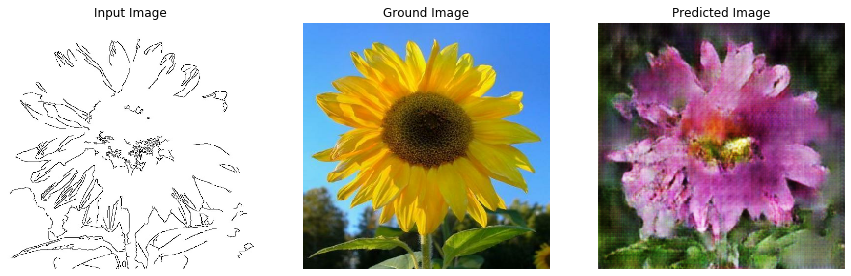

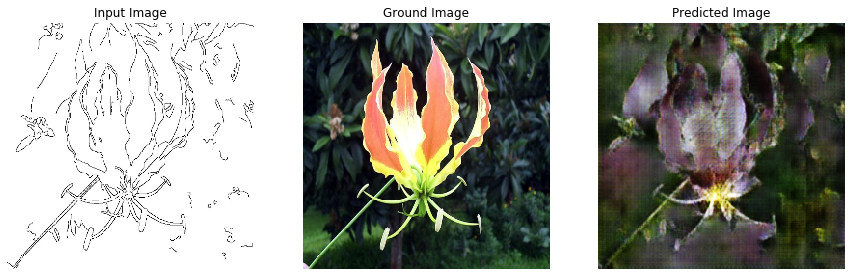

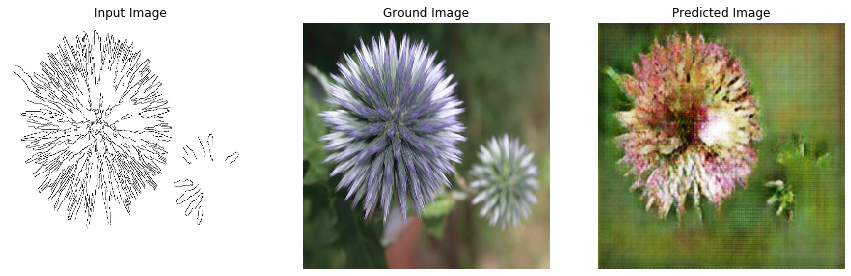

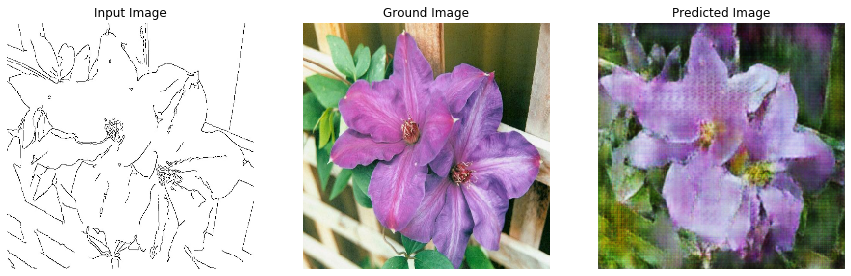

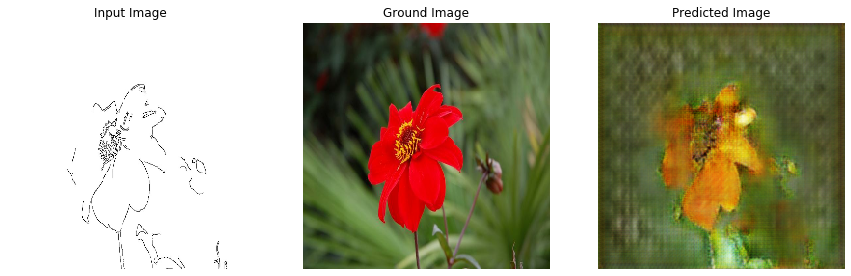

In [21]:
train(train_dataset,100)

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

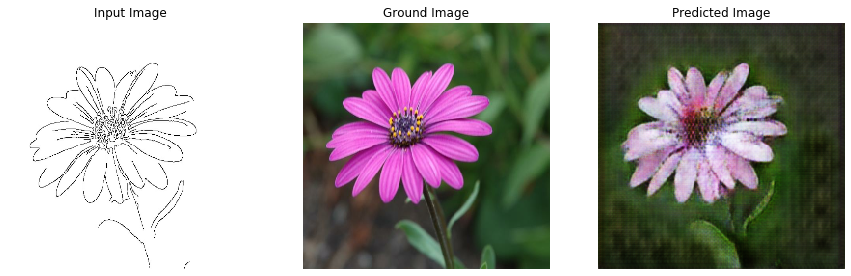

In [73]:
num = 65
generate_images(Generator, tf.expand_dims(load_test_image(randurls[num])[0],0),tf.expand_dims(load_test_image(randurls[num])[1],0))